In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras import backend
import time

Using TensorFlow backend.


In [3]:

def _x(t,data):
    return 0 if t < 0 else data[t]

def x(t,data):
    beta = 0.2
    gamma = 0.1
    tau = 25
    n = 10
    return _x(t-1,data) + (beta*_x(t-tau-1,data))/(1+_x(t-tau-1,data)**n) - gamma*_x(t-1,data)

def mackey_glass_generator():


    N = 2000

    data = np.zeros(N)
    data[0] = 1.5

    for t in range(1,N):
        data[t] = x(t,data)

    return data
def get_train_test_data(x,addNoise=1,sigma=1):
    train_set = np.zeros([1000,5])
    train_labels = np.zeros([1000])
    
    for t in range(300,1300):
        train_set[t-300,:] = [x[t-20], x[t-15], x[t-10], x[t-5], x[t]]
        train_labels[t-300] = x[t+5] 

    test_set = np.zeros([200,5])
    test_labels = np.zeros([200])
    
    for t in range(1300,1500):
        test_set[t-1300,:] = [x[t-20], x[t-15], x[t-10], x[t-5], x[t]]
        test_labels[t-1300] = x[t+5] 
        
    if addNoise:
        noise = np.random.normal(0,sigma,train_set.shape)
        train_set = train_set+noise
        
    return train_set, train_labels, test_set, test_labels

def init_network(num_nodes, lambd):
    if len(num_nodes) < 1:
        return None

    model = Sequential()

    num_layers = len(num_nodes)
    model.add(Dense(num_nodes[0], input_dim=5, kernel_initializer='normal', activation='relu',use_bias=True, activity_regularizer=regularizers.l2(lambd)))
    for i in range(1, num_layers):
        model.add(Dense(num_nodes[i], kernel_initializer='normal', activation='relu', use_bias=True, activity_regularizer=regularizers.l2(lambd)))
    model.add(Dense(1, kernel_initializer='normal', activation='relu', use_bias=True, activity_regularizer=regularizers.l2(lambd)))
    #not sparse data so we use L2 reg
    model.summary()
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='mse',metrics=['MSE'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=100)
    return model, es

In [4]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [80]:
def error_mse(T, Y):
    #return np.sum((T - Y) ** 2) / 2
    return np.mean(((Y-T)**2))


nodes_first_layer = 8
nodes_second_layer = 8
std = 0.09
lamb = 1e-4
nValidation = 5
nEpochs = 5000

elapsed_training_time_2l = []
elapsed_training_time_3l = []

mse_2l = []
mse_3l = []

mse_val_2l = []
mse_val_3l = []

data_mg = mackey_glass_generator()

for iterations in range(nValidation):
    train_set, train_labels, test_set, test_labels = get_train_test_data(data_mg,1,std)

    model_2l, early_stopping_2l = init_network([nodes_first_layer],lamb)
    model_3l, early_stopping_3l = init_network([nodes_first_layer,nodes_second_layer],lamb)
    
    time_callback_2l = TimeHistory()
    time_callback_3l = TimeHistory()
    
    #start = time.clock()
    history_2l = model_2l.fit(train_set, train_labels, epochs=nEpochs, batch_size=50, validation_split=0.2,  callbacks=[time_callback_2l], verbose=0)
    history_3l = model_3l.fit(train_set, train_labels, epochs=nEpochs, batch_size=50, validation_split=0.2,  callbacks=[time_callback_3l], verbose=0)
    #stop = time.clock()
        
    #elapsed_training_time.append(stop-start)
    
    elapsed_training_time_2l.append(np.sum(time_callback_2l.times))
    elapsed_training_time_3l.append(np.sum(time_callback_3l.times))
    
    mse_2l.append(history_2l.history['MSE'])
    mse_3l.append(history_3l.history['MSE'])
    
    mse_val_2l.append(history_2l.history['val_MSE'])
    mse_val_3l.append(history_3l.history['val_MSE'])
    
    
  

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 8)                 48        
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 9         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 8)                 48        
_________________________________________________________________
dense_149 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 9         
Total params: 129
Trainable params

In [58]:
def conv2arr(dlist):
    arr = np.zeros((len(dlist),len(dlist[-1])))
    #print(arr.shape)
    for i,lis in enumerate(dlist):
        for j,elem in enumerate(lis):
            #print(i,j)
            arr[i,j] = elem
    return arr
            

In [88]:
mse_2l = conv2arr(mse_2l)
mse_3l = conv2arr(mse_3l)
mse_val_2l = conv2arr(mse_val_2l)
mse_val_3l = conv2arr(mse_val_3l)

var_mse2l = np.var(mse_2l,axis=0)
var_mse3l = np.var(mse_3l,axis=0)
var_mseval2l = np.var(mse_val_2l,axis=0)
var_mseval3l = np.var(mse_val_3l,axis=0)

mse2l_mean = np.mean(mse_2l,axis=0)
mse3l_mean = np.mean(mse_3l,axis=0)
mseval2l_mean = np.mean(mse_val_2l,axis=0)
mseval3l_mean = np.mean(mse_val_3l,axis=0)

print('Training time mlp2: '+str(np.mean(np.array(elapsed_training_time_2l)))+' [s]')
print('Training time mlp3: '+str(np.mean(np.array(elapsed_training_time_3l)))+' [s]')

Training time mlp2: 121.80310020446777 [s]
Training time mlp3: 124.23689341545105 [s]


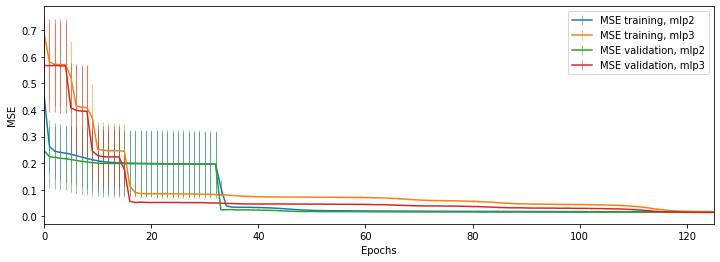

In [85]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(111)

ax1.errorbar(np.linspace(0,nEpochs,nEpochs),mse2l_mean,yerr=var_mse2l,elinewidth=0.5,label='MSE training, mlp2')
ax1.errorbar(np.linspace(0,nEpochs,nEpochs),mse3l_mean,yerr=var_mse3l,elinewidth=0.5,label='MSE training, mlp3')
ax1.errorbar(np.linspace(0,nEpochs,nEpochs),mseval2l_mean,yerr=var_mseval2l,elinewidth=0.5,label='MSE validation, mlp2')
ax1.errorbar(np.linspace(0,nEpochs,nEpochs),mseval3l_mean,yerr=var_mseval3l,elinewidth=0.5,label='MSE validation, mlp3')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')
ax1.set_xlim([0,125])
ax1.legend()



plt.show()

Omöjligt att säga något om tiden...